<a href="https://colab.research.google.com/github/isdrael4590/DIALUNG/blob/main/notebooks/ImplementacionModelos/DIALUNG_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arquitectura de Red Resnet50
Basado en la librería de [TorchXRayVision]https://github.com/mlmed/torchxrayvision)

In [1]:
import numpy as np
import pandas as pd
import os
mapa_condiciones = {
    0: "normal",
    1: "tuberculosis",
    2: "neumonia",
    3: "covid-19"
}

In [17]:
!pip install torchxrayvision torchio tqdm torchinfo cockpit-for-pytorch torch-lr-finder

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My\ Drive/ProyectoDIALUNG/
#Archivo local 
#%cd /media/josejacomeb/Datos1/DatasetsMédicos/ProyectoDIALUNG/

/content/drive/.shortcut-targets-by-id/1RXSTiiN9YE5Ea3wLZhtV6QSDvbNxBQVq/ProyectoDIALUNG


In [5]:
direccion_dataset_imagenes = "DIALUNG-Datasets/"
dataset_train_256 = os.path.join(direccion_dataset_imagenes, "train_512.hdf5") 
dataset_test_256 = os.path.join(direccion_dataset_imagenes, "test_512.hdf5")
dataset_val_256 = os.path.join(direccion_dataset_imagenes, "val_512.hdf5")

In [6]:
#Tamaño deseado de la imagen
ancho_imagen_deseado  = 512
alto_imagen_deseado =  512
#Variables de rotación
probabilidad_rotacion = 0.20
angulo_rotacion_grados = 45
#Variables de Blur
probabilidad_blur = 0.05
std_filtro_gaussiano = (1, 1)
#Variables de Ruido
probabilidad_ruido = 0.05
std_ruido_gaussiano = (0, 0.08)
mean_ruido_gaussiano = 0
# Variables de Desplazamiento
probabilidad_desplazamiento = 0.20
desplazamiento_x_y = (0.25, 0.25) #1 mm de desplazamiento en ambos ejes 
# Variables de escalado
probabilidad_escalado = 0.20
escalada = (0.85, 0.85)
# Tamaño del batch
batch_size = 22

In [7]:
from torchvision.transforms import Compose #Compose me sirve para apilar varias transformaciones en una sola
from torchvision.transforms import Resize #Cargar herramienta para hacer Rescalado
from torchvision.transforms import Lambda #Convertir tensor de salida a one-hot-encoded 
import torch 
#Librerias de TorchIO
import torchio as tio
#Librerias de DIALUNG
from dialung.utils.creardatasetbinario import crearDatasetBinarioDIALUNG

resize_transform = tio.Resize((alto_imagen_deseado, ancho_imagen_deseado, 1)) #Cambiar el tamaño al establecido en la celda de arriba
normalizacion_dataset = tio.transforms.ZNormalization()
rescalar_intensidad = tio.transforms.RescaleIntensity(out_min_max=(0, 1)) #Rescalar 0 o 1
#Diccionario de transformaciones con su probabilidad de ser ejecutadas
diccionario_transformaciones = {
  tio.RandomAffine(degrees = angulo_rotacion_grados): probabilidad_rotacion, #transformacion de rotación  
  tio.transforms.RandomBlur(std = std_filtro_gaussiano): probabilidad_blur, #transformacion de blur  
  tio.transforms.RandomNoise(mean = mean_ruido_gaussiano, std = std_ruido_gaussiano): probabilidad_ruido, #transformaciones de ruido
  tio.RandomAffine(translation = desplazamiento_x_y): probabilidad_desplazamiento, #transformacion de traslación 
  tio.RandomAffine(scales = escalada): probabilidad_escalado, #probabilidad escalado
}
#Agrupar todas las transformaciones en una sola
transformaciones_DIALUNG = tio.OneOf(diccionario_transformaciones)

transformaciones_dataset = Compose([resize_transform, transformaciones_DIALUNG, rescalar_intensidad]) #Apila las transformaciones
transformacion_salida = Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(int(y)), value=1)) #Hago un

#Creo objetos de tipo crearDatasetDIALUNG
train_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_train_256, transformaciones_dataset, rgb = False)
test_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_test_256, transformaciones_dataset, rgb = False)
val_datasetDIALUNG = crearDatasetBinarioDIALUNG(dataset_val_256, transformaciones_dataset, rgb = False)

In [8]:
from torch.utils.data import DataLoader #Clase dataloader para cargar en PyTorch los objetos de tipo Dataset

#Creo objetos de tipo DataLoader en lotes de 64 imagenes y barajeados aleatoriamente
train_dataloader = DataLoader(train_datasetDIALUNG, batch_size=batch_size, shuffle=True, num_workers = 2)
test_dataloader = DataLoader(test_datasetDIALUNG, batch_size=batch_size, shuffle=False, num_workers = 2)
val_dataloader = DataLoader(val_datasetDIALUNG, batch_size=batch_size, shuffle=False, num_workers = 2)

In [24]:
from torch import nn
from collections import OrderedDict
from datetime import date
from torch.utils.tensorboard import SummaryWriter

#Configuracion de datos de cada experimento
carpeta_experimentos = "DIALUNG_Experimentos"
carpeta_metricas, carpeta_modelos, carpeta_logs = "Métricas", "Modelos", "logs_dir"
nombre_modelo = "Resnet50" #Poner el nombre cada uno de su modelo
implementado_por= "josejacomeb" #Poner sus nombres 
nombre_experimento = os.path.join(implementado_por, nombre_modelo)
ruta_guardar_metricas = os.path.join(carpeta_experimentos, carpeta_metricas, nombre_experimento)
ruta_guardar_modelos = os.path.join(carpeta_experimentos, carpeta_modelos, nombre_experimento)
ruta_guardar_logs = os.path.join(carpeta_experimentos, carpeta_logs, nombre_experimento)
#Creo los directorios
if not os.path.exists(ruta_guardar_metricas):
    os.makedirs(ruta_guardar_metricas)
if not os.path.exists(ruta_guardar_modelos):
    os.makedirs(ruta_guardar_modelos)
if not os.path.exists(ruta_guardar_logs):
    os.makedirs(ruta_guardar_logs)
#Inicializar TensorBoard para escribir los datos en el directorio de ruta_guardar_logs
writer = SummaryWriter(ruta_guardar_logs)

In [25]:
dispositivo = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(dispositivo))

Using cuda device


In [28]:
import torchxrayvision as xrv #Importar la librería TorchXRayVision
from torch import nn

modelo = xrv.models.ResNet(weights="resnet50-res512-all")
in_features = modelo.model.fc.in_features 
num_clases = len(mapa_condiciones.values())
modelo.op_threshs = None #Previene calibracion del modelo
modelo.model.fc = nn.Linear(in_features=in_features, out_features=num_clases) #Cambio la capa de salida para ajustar a los cuatro parámetros
modelo.to(dispositivo)

XRV-ResNet-resnet50-res512-all

In [29]:
# Obtener algunas imagenes para mostrar en TensorBoard
images, labels = next(iter(val_dataloader))
images = images.to(dispositivo)
#Añadir el modelo a tensorboard
writer.add_graph(modelo, images)

In [30]:
from torchinfo import summary 
print(summary(modelo, input_size = tuple(images.shape)))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        --                        --
├─ResNet: 1-1                                 [22, 4]                   --
│    └─Conv2d: 2-1                            [22, 64, 256, 256]        3,136
│    └─BatchNorm2d: 2-2                       [22, 64, 256, 256]        128
│    └─ReLU: 2-3                              [22, 64, 256, 256]        --
│    └─MaxPool2d: 2-4                         [22, 64, 128, 128]        --
│    └─Sequential: 2-5                        [22, 256, 128, 128]       --
│    │    └─Bottleneck: 3-1                   [22, 256, 128, 128]       75,008
│    │    └─Bottleneck: 3-2                   [22, 256, 128, 128]       70,400
│    │    └─Bottleneck: 3-3                   [22, 256, 128, 128]       70,400
│    └─Sequential: 2-6                        [22, 512, 64, 64]         --
│    │    └─Bottleneck: 3-4                   [22, 512, 64, 64]         379,392

In [31]:
learning_rate_inicial = 0.04
epochs = 25
momentum = 0.9 #Momento del algoritmo SGD
weight_decay = 0.05 #Weight decay
learning_rate_manual = None #Poner el numero deseado si se requiere

In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
pesos_clase_desbalanceada = torch.tensor([0.5097178 , 2.12377522, 1.0953478 , 1.52830776]).to(dispositivo) 
funcion_perdida = nn.CrossEntropyLoss(weight = pesos_clase_desbalanceada) #Uso de CrossEntropy
optimizador = torch.optim.SGD(modelo.parameters(), lr=learning_rate_inicial, 
                              momentum=momentum, weight_decay=weight_decay) #Optimizador SGD
scheduler = ReduceLROnPlateau(optimizador, "min", patience = 5, factor = 0.30, min_lr = 1e-5)

In [33]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir $ruta_guardar_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-9717aaeb04a0>", line 3, in <module>
    get_ipython().magic('tensorboard --logdir $ruta_guardar_logs')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/notebook.py", line 117, in _start_magic
    return start(line)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/notebook.py", line 152, in start
    start_result = manager.start(parsed_args)
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/manager.py", line 401, in start
    working_directory=os.

FileNotFoundError: ignored

In [ ]:
from dialung.entrenarvalidar import EntrenamientoValidacionDIALUNG

ruta_ultimo_archivo_pesos = os.path.join(ruta_guardar_modelos, "ultimo.pt") #mejor.pt si algo falló en el proceso
epoch_inicio = 0
resumir_entrenamiento = False
step_inicio = 0
historico = None

if os.path.exists(ruta_ultimo_archivo_pesos):
    resumir_entrenamiento = True
    checkpoint = torch.load(ruta_ultimo_archivo_pesos)
    modelo.load_state_dict(checkpoint["model_state_dict"])#cargar los pesos del modelo
    optimizador.load_state_dict(checkpoint["optimizer_state_dict"]) #carga el modelo del optimizador
    #Checar por una nuevo lr seleccionado por el usuario
    if learning_rate_manual:
        print("Cambiando el learning rate manualmente a: {}".format(learning_rate_manual))
        optimizador.param_groups[0]["lr"] = learning_rate_manual
    if momentum != optimizador.param_groups[0]["momentum"]:
        optimizador.param_groups[0]["momentum"] = momentum
    
    epoch_inicio = checkpoint["epoch"]
    step_inicio = checkpoint["steps"]
    historico = checkpoint["historico"]
    print("Resumiendo el entrenamiento desde la época: {}".format(epoch_inicio))
else:
    print("No hay un checkpoint guardado, iniciando el entrenamiento desde la época 0")

ent_val_DIALUNG = EntrenamientoValidacionDIALUNG(modelo = modelo, funcion_perdida = funcion_perdida,
                                                 dispositivo = dispositivo, optimizador = optimizador, 
                                                 scheduler = scheduler, #ruta_writer=ruta_guardar_logs,
                                                debugger=True)
if resumir_entrenamiento:
    ent_val_DIALUNG.cargar_anteriores_resultados(historico, step_inicio)

for epoch in range(epoch_inicio, epochs):
    print(f"Época {epoch+1}\n-------------------------------")
    ent_val_DIALUNG.entrenar(train_dataloader)
    ent_val_DIALUNG.validar(test_dataloader)
    ent_val_DIALUNG.guardar_modelo(ruta_modelo=ruta_guardar_modelos, #Guardar modelo y Métricas
                                   ruta_metricas=ruta_guardar_metricas, epoch=epoch)
print("Entrenamiento finalizado!")
ent_val_DIALUNG.plotter(ent_val_DIALUNG.cockpit, block = True)

No hay un checkpoint guardado, iniciando el entrenamiento desde la época 0
Modelo no soportado por el Debugger, verifique que sea Secuencial o ResNET
Época 1
-------------------------------
## Entrenamiento ##


Progreso dataset entrenamiento(batches):   0%|          | 0/670 [00:00<?, ?it/s]

Valor Función pérdida: 1.389 Precisión: 45.15%  Tasa de aprendizaje: 0.04
Tiempo de iteración: 0:27:41.450344
## Validación ##


Progreso dataset evaluacion (Batches):   0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.49      1.00      0.66      1356
tuberculosis       0.00      0.00      0.00       325
    neumonia       0.00      0.00      0.00       630
    covid-19       0.00      0.00      0.00       452

    accuracy                           0.49      2763
   macro avg       0.12      0.25      0.16      2763
weighted avg       0.24      0.49      0.32      2763

Valor Función pérdida: 1.386 Precisión: 49.08 %
Tiempo de iteración: 0:01:46.613330
Época 2
-------------------------------
## Entrenamiento ##


Progreso dataset entrenamiento(batches):   0%|          | 0/670 [00:00<?, ?it/s]

Valor Función pérdida: 1.388 Precisión: 49.05%  Tasa de aprendizaje: 0.04
Tiempo de iteración: 0:28:24.236234
## Validación ##


Progreso dataset evaluacion (Batches):   0%|          | 0/126 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      normal       0.49      1.00      0.66      1356
tuberculosis       0.00      0.00      0.00       325
    neumonia       0.00      0.00      0.00       630
    covid-19       0.00      0.00      0.00       452

    accuracy                           0.49      2763
   macro avg       0.12      0.25      0.16      2763
weighted avg       0.24      0.49      0.32      2763

Valor Función pérdida: 1.386 Precisión: 49.08 %
Tiempo de iteración: 0:01:34.680045
Época 3
-------------------------------
## Entrenamiento ##


Progreso dataset entrenamiento(batches):   0%|          | 0/670 [00:00<?, ?it/s]

# Buscar el LR apropiado

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Failed to compute the gradients, there might not be enough points.


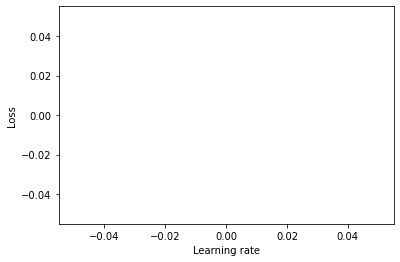

In [19]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelo.parameters(), lr=learning_rate_inicial, momentum=momentum, weight_decay=weight_decay) #Optimizador SGD#torch.optim.Adam(modelo.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = LRFinder(modelo, optimizer, criterion, device=dispositivo)
lr_finder.range_test(train_dataloader, val_loader=test_dataloader, end_lr=10, num_iter=100, step_mode="linear")
#lr_finder.range_test(train_dataloader, end_lr=10, num_iter=200)
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
!pip install torch-lr-finder